In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
import scipy.misc as misc
from IPython.display import Image, display
import os
import PIL

In [2]:
image_size = 224
num_classes = 151

batch_size = 3

model_name = "FCN4"
model_directory = os.getcwd() + "/SavedModel/" + model_name
model_filename = model_name + "Model.ckpt"
model_path = model_directory + "/" + model_filename

# Get Data

In [3]:
def list_files(dire):
    r= []
    names = []
    for root, dirs, files in os.walk(dire):
        for name in files:
            r.append(dire+'/' + name)
    return r

In [35]:
training_list= list_files(os.getcwd() + '/data/MIT_SceneParsing/ADEChallengeData2016/images/training')
validation_list= list_files(os.getcwd() + '/data/MIT_SceneParsing/ADEChallengeData2016/images/validation')

training_label_list= list_files(os.getcwd() + '/data/MIT_SceneParsing/ADEChallengeData2016/annotations/training')
validation_label_list= list_files(os.getcwd() + '/data/MIT_SceneParsing/ADEChallengeData2016/annotations/validation')

In [36]:
def imageToArray(filename, size):
    image = misc.imread(filename)
    resize_image = misc.imresize(image, [size, size], interp='nearest')
    
    return np.array(resize_image)

def loadDataSet(data_list, label_list):
    dataset = []
    dataset_labels = []
    for filename in data_list:
        dataset.append(np.array(imageToArray(filename, image_size)))
    for filename in label_list:
        dataset_labels.append(np.array(imageToArray(filename, image_size)))

    return dataset, dataset_labels

In [34]:
training_data, training_labels = loadDataSet(training_list, training_label_list)

NameError: name 'training_list' is not defined

In [ ]:
validation_data, validation_labels = loadDataSet(validation_list, validation_label_list)

In [4]:
import pickle

def cacheData(data_name, label_name, data, label):
    with open(data_name, 'wb') as f:
        pickle.dump(data, f)
    with open(label_name, 'wb') as f:
        pickle.dump(label, f)
        
def loadData(data_name, label_name):
    data = pickle.load(open(data_name, 'rb'))
    label = pickle.load(open(label_name, 'rb'))
    return data, label

In [5]:
validation_data, validation_labels = loadData('valid_data.pkl', 'valid_labels.pkl')
training_data, training_labels = loadData('training_data', 'training_labels')

In [ ]:
cacheData('valid_data.pkl', 'valid_labels.pkl', validation_data, validation_labels)
cacheData('training_data.pkl', 'training_labels.pkl', training_data, training_labels)

### Editting images that are the incorrect shape
There are a few non rgb images that we need to change to rgb so the model will accept it

In [9]:
lt = len(training_data)

for i in range(0, lt):
    b = np.array(training_data[i])
    if b.shape == (image_size, image_size):
        print(str(i) + " " + str(b.shape))
        temp = np.empty([image_size, image_size, 3])
        temp.shape
        temp[:,:,0] = training_data[i]
        temp[:,:,1] = training_data[i]
        temp[:,:,2] = training_data[i]
        training_data[i] = temp
        
training_labels = np.reshape(training_labels, [-1, image_size, image_size, 1])
validation_labels = np.reshape(validation_labels, [-1, image_size, image_size, 1])

1700 (224, 224)
3019 (224, 224)
8454 (224, 224)
13507 (224, 224)


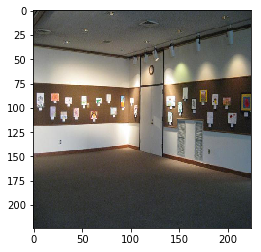

In [10]:
plt.imshow(training_data[2])

In [37]:
def createConvolutionLayerNew(x_input, kernel_size, features, depth):
    # createConvolutionLayer generates a convolution layer in the session graph
    # by assigning weights, biases, convolution and relu function
    #
    # x_input - output from the previous layer
    # kernel_size - size of the feature kernels
    # features - number of feature kernels
    # depth - number of feature kernels
    #
    # returns convolution layer in graph
    #
    #print("conv: input size: " + str(x_input.get_shape()))
    weights = tf.get_variable('weights', initializer = tf.truncated_normal([kernel_size, kernel_size, features, depth], stddev=0.02))

    biases = tf.get_variable('biases', shape=[depth], initializer=tf.constant_initializer(0))

    convolution = tf.nn.conv2d(x_input, weights, strides=[1,1,1,1], padding='SAME')
    print("wF: " + str(weights.get_shape()))
    print("bF: " + str(biases.get_shape()))
    added = tf.nn.bias_add(convolution, biases)

    return tf.nn.relu(added)

In [15]:
def createConvolutionLayer(x_input, _weights, _biases, kernel_size, features, depth):
    # createConvolutionLayer generates a convolution layer in the session graph
    # by assigning weights, biases, convolution and relu function
    #
    # x_input - output from the previous layer
    # kernel_size - size of the feature kernels
    # depth - number of feature kernels
    #
    # returns convolution layer in graph
    # 
    weights = tf.get_variable('weights', initializer=tf.constant_initializer(np.transpose(_weights, (1, 0, 2, 3)), dtype=tf.float32),  shape=_weights.shape)
    
    biases = tf.get_variable('biases', initializer=tf.constant_initializer(_biases.reshape(-1), dtype=tf.float32),  shape=_biases.reshape(-1).shape)
    
    #print("conv: input size: " + str(x_input.get_shape()))
    convolution = tf.nn.conv2d(x_input, weights, strides=[1,1,1,1], padding='SAME')
    
    print("w: " + str(weights.get_shape()))
    print("b: " + str(biases.get_shape()))
    added = tf.nn.bias_add(convolution, biases)
    
    return tf.nn.relu(added)

In [41]:
def createConvolutionTransposeLayer(x_input, output_shape, weight_shape, stride=2):
        
    weights = tf.get_variable('weights', initializer = tf.truncated_normal(weight_shape, stddev=0.02))
    biases = tf.get_variable('biases', shape=[weight_shape[2]], initializer=tf.constant_initializer(0))
    print("xInp: " + str(x_input.get_shape()))
    print("xOut: " + str(output_shape.get_shape()))
    print("wTrans: " + str(weights.get_shape()))
    print("bTrans: " + str(biases.get_shape()))
    convolution = tf.nn.conv2d_transpose(x_input, weights, output_shape, strides=[1,stride,stride,1], padding = 'SAME')
    return tf.nn.bias_add(convolution, biases)

In [18]:
def createFullyConnectedLayer(x_input, width):
    # createFullyConnectedLayer generates a fully connected layer in the session graph
    # 
    # x_input - output from previous layer
    # width - width of the layer (eg for a 10 class output you need to end with a 10 width layer
    #
    # returns fully connected layer in graph
    #
    #print("fc: input size: " + str(x_input.get_shape()))
    weights = tf.get_variable('weights', shape=[x_input.get_shape()[1], width],
                             initializer = tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable('biases', shape=[width], initializer=tf.constant_initializer(0))
     
    matrix_multiply = tf.matmul(x_input, weights)
    
    return tf.nn.bias_add(matrix_multiply, biases)

In [19]:
def createLinearRectifier(x_input):
    # createLinearRectifier generates a ReLu in the session graph
    # 
    # The reason this exists is due to the last fully connected layer not needing a relu while others do
    # x_input - output from previous layer
    # width - width of the layer
    #
    # returns ReLu in graph
    # 
    
    return tf.nn.relu(x_input)

In [20]:
def createPoolingLayer(x_input, kernel_size, pool_type):
    # createPoolingLayer generates a pooling layer in the session graph
    # 
    # The reason this exists is due to the last fully connected layer not needing a relu while others do
    # x_input - output from previous layer
    # kernel_size - size of the kernel
    #
    # returns pooling layer in graph
    # 
    #print("pool: input size: " + str(x_input.get_shape()))
    #change to average pooling
    if pool_type == 'max':
        return tf.nn.max_pool(x_input, ksize=[1, kernel_size, kernel_size, 1], strides=[1,kernel_size, kernel_size, 1], padding='SAME')
    else:
        return tf.nn.avg_pool(x_input, ksize=[1, kernel_size, kernel_size, 1], strides=[1,kernel_size, kernel_size, 1], padding='SAME')
    

# Define VGG Model

In [28]:
#conv1.1 3x3, 64
#conv1.2 3x3, 64
#
#pool 2
#
#conv2.1 3x3, 128
#conv2.2 3x3, 128
#
#pool 2
#
#conv3.1 3x3, 256
#conv3.2 3x3, 256
#conv3.3 3x3, 256
#conv3.4 3x3, 256
#
#pool 2
#
#conv 4.1 3x3, 512
#conv 4.2 3x3, 512
#conv 4.3 3x3, 512
#conv 4.4 3x3, 512
#
#pool 2
#
#conv 5.1 3x3, 512
#conv 5.2 3x3, 512
#conv 5.3 3x3, 512
#conv 5.4 3x3, 512
#
#pool 2
#FC 4k
#FC 4k
#FC 1000

def createVGG19(x_input, layer_weights, is_training):
    
    with tf.variable_scope('conv11'):
        kernel_weights, bias_weights = layer_weights[0][0][0][0][0]
        convolution_layer11 = createConvolutionLayer(x_input, kernel_weights, bias_weights, 3, 1, 64)
    with tf.variable_scope('conv12'):
        kernel_weights, bias_weights = layer_weights[2][0][0][0][0]
        convolution_layer12 = createConvolutionLayer(convolution_layer11, kernel_weights, bias_weights, 3, 64, 64)
        pooling_layer1 = createPoolingLayer(convolution_layer12, 2, 'avg')
        
    with tf.variable_scope('conv21'):
        kernel_weights, bias_weights = layer_weights[5][0][0][0][0]
        convolution_layer21 = createConvolutionLayer(pooling_layer1, kernel_weights, bias_weights, 3, 64, 128)
    with tf.variable_scope('conv22'):
        kernel_weights, bias_weights = layer_weights[7][0][0][0][0]
        convolution_layer22 = createConvolutionLayer(convolution_layer21, kernel_weights, bias_weights, 3, 128, 128)
        pooling_layer2 = createPoolingLayer(convolution_layer22, 2, 'avg')
        
    with tf.variable_scope('conv31'):
        kernel_weights, bias_weights = layer_weights[10][0][0][0][0]
        convolution_layer31 = createConvolutionLayer(pooling_layer2, kernel_weights, bias_weights, 3, 1, 256)
    with tf.variable_scope('conv32'):
        kernel_weights, bias_weights = layer_weights[12][0][0][0][0]
        convolution_layer32 = createConvolutionLayer(convolution_layer31, kernel_weights, bias_weights, 3, 1, 256)
    with tf.variable_scope('conv33'):
        kernel_weights, bias_weights = layer_weights[14][0][0][0][0]
        convolution_layer33 = createConvolutionLayer(convolution_layer32, kernel_weights, bias_weights, 3, 1, 256)
    with tf.variable_scope('conv34'):
        kernel_weights, bias_weights = layer_weights[16][0][0][0][0]
        convolution_layer34 = createConvolutionLayer(convolution_layer33, kernel_weights, bias_weights, 3, 1, 256)
        pooling_layer3 = createPoolingLayer(convolution_layer34, 2, 'avg')
        
    with tf.variable_scope('conv41'):
        kernel_weights, bias_weights = layer_weights[19][0][0][0][0]
        convolution_layer41 = createConvolutionLayer(pooling_layer3, kernel_weights, bias_weights, 3, 1, 512)
    with tf.variable_scope('conv42'):
        kernel_weights, bias_weights = layer_weights[21][0][0][0][0]
        convolution_layer42 = createConvolutionLayer(convolution_layer41, kernel_weights, bias_weights, 3, 1, 512)
    with tf.variable_scope('conv43'):
        kernel_weights, bias_weights = layer_weights[23][0][0][0][0]
        convolution_layer43 = createConvolutionLayer(convolution_layer42, kernel_weights, bias_weights, 3, 1, 512)
    with tf.variable_scope('conv44'):
        kernel_weights, bias_weights = layer_weights[25][0][0][0][0]
        convolution_layer44 = createConvolutionLayer(convolution_layer43, kernel_weights, bias_weights, 3, 1, 512)
        pooling_layer4 = createPoolingLayer(convolution_layer44, 2, 'avg')
    
    with tf.variable_scope('conv51'):
        kernel_weights, bias_weights = layer_weights[28][0][0][0][0]
        convolution_layer51 = createConvolutionLayer(pooling_layer4, kernel_weights, bias_weights, 3, 1, 512)
    with tf.variable_scope('conv52'):
        kernel_weights, bias_weights = layer_weights[30][0][0][0][0]
        convolution_layer52 = createConvolutionLayer(convolution_layer51, kernel_weights, bias_weights, 3, 1, 512)
    with tf.variable_scope('conv53'):
        kernel_weights, bias_weights = layer_weights[32][0][0][0][0]
        convolution_layer53 = createConvolutionLayer(convolution_layer52, kernel_weights, bias_weights, 3, 1, 512)
    with tf.variable_scope('conv54'):
        kernel_weights, bias_weights = layer_weights[34][0][0][0][0]
        convolution_layer54 = createConvolutionLayer(convolution_layer53, kernel_weights, bias_weights, 3, 1, 512)
        pooling_layer5 = createPoolingLayer(convolution_layer53, 2, 'max')
        
    with tf.variable_scope('fc1'):
        print('fc1')
        full_convolution_layer6 = createConvolutionLayerNew(pooling_layer5, 7, 512, 4096)
        fully_connected_relu6 = createLinearRectifier(full_convolution_layer6)
        fully_connected_relu6 = tf.cond(is_training, lambda: tf.nn.dropout(fully_connected_relu6, keep_prob = 0.85 if dropout else 1.0), lambda: fully_connected_relu6)
    
        
        #need dropout
    with tf.variable_scope('fc2'):
        full_convolution_layer7 = createConvolutionLayerNew(fully_connected_relu6, 1, 4096, 4096)
        fully_connected_relu7 = createLinearRectifier(full_convolution_layer7)
        fully_connected_relu7 = tf.cond(is_training, lambda: tf.nn.dropout(fully_connected_relu7, keep_prob = 0.85 if dropout else 1.0), lambda: fully_connected_relu7)
    
        # need dropout
    with tf.variable_scope('fc3'):
        full_convolution_layer8 = createConvolutionLayerNew(fully_connected_relu7, 1, 4096, num_classes)
        #full_convolution_layer8 = createConvolutionLayerNew(full_convolution_layer8, 3, 1, 512)
        
    return full_convolution_layer8, pooling_layer4, pooling_layer3

In [29]:
def createDeconvolutionNetwork(x_input, orig_input, pool_fuse1, pool_fuse2):
    
    with tf.variable_scope('dc1'):
        deconvolution_layer1 = createConvolutionTransposeLayer(x_input, tf.shape(pool_fuse1), [4, 4, pool_fuse1.get_shape()[3].value, num_classes], stride=2)
        print("dc1: " + str(deconvolution_layer1.get_shape()))
        #fuse layer with pool 4
        fuse_layer1 = tf.add(pool_fuse1, deconvolution_layer1)
        print("fuse1: " + str(fuse_layer1.get_shape()))
        
    with tf.variable_scope('dc2'):
        deconvolution_layer2 = createConvolutionTransposeLayer(fuse_layer1, tf.shape(pool_fuse2), [4, 4, pool_fuse2.get_shape()[3].value, pool_fuse1.get_shape()[3].value], stride=2)
        print("dc2: " + str(deconvolution_layer2.get_shape()))
        #fuse layer with pool 3
        fuse_layer2 = tf.add(pool_fuse2, deconvolution_layer2)
        print("fuse2: " + str(fuse_layer2.get_shape()))
        
    with tf.variable_scope('dc3'):
        #determine size
        shape1 = tf.shape(orig_input)
        shape2 = tf.pack([shape1[0], shape1[1], shape1[2], num_classes])
        #conv layer
        deconvolution_layer3 = createConvolutionTransposeLayer(fuse_layer2, shape2, [16, 16, num_classes, pool_fuse2.get_shape()[3].value], stride=8)
        print("output_layer: " + str(deconvolution_layer3.get_shape()))
        
    output = tf.argmax(deconvolution_layer3, dimension=3)
    
    return tf.expand_dims(output, dim=3), deconvolution_layer3

In [30]:
import scipy.io

def get_model_data(dir_path):
    filename = "imagenet-vgg-verydeep-19.mat"
    filepath = os.path.join(dir_path, filename)
    if not os.path.exists(filepath):
        printf("Model File not found")
    data = scipy.io.loadmat(filepath)
    return data

In [31]:
model_data = get_model_data("model/")
mean = model_data['normalization'][0][0][0]
mean_pixel = np.mean(mean, axis=(0, 1))
weights = np.squeeze(model_data['layers'])

# Build Network

In [42]:
#Build the network
graph = tf.Graph()
with graph.as_default():
    
    x_input = tf.placeholder(tf.float32, shape=[None, image_size, image_size, 3])
    y_output = tf.placeholder(tf.int32, shape=[None, image_size, image_size, 1])
    is_training = tf.placeholder(tf.bool)
    
    output, pool4, pool3 = createVGG19(x_input-mean_pixel, weights, is_training)
    prediction_output, logits = createDeconvolutionNetwork(output, x_input, pool4, pool3)

    learning_rate = .0001

    loss_function = tf.reduce_mean((tf.nn.sparse_softmax_cross_entropy_with_logits(logits, tf.squeeze(y_output, squeeze_dims=[3]))))
    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss_function)

w: (3, 3, 3, 64)
b: (64,)
w: (3, 3, 64, 64)
b: (64,)
w: (3, 3, 64, 128)
b: (128,)
w: (3, 3, 128, 128)
b: (128,)
w: (3, 3, 128, 256)
b: (256,)
w: (3, 3, 256, 256)
b: (256,)
w: (3, 3, 256, 256)
b: (256,)
w: (3, 3, 256, 256)
b: (256,)
w: (3, 3, 256, 512)
b: (512,)
w: (3, 3, 512, 512)
b: (512,)
w: (3, 3, 512, 512)
b: (512,)
w: (3, 3, 512, 512)
b: (512,)
w: (3, 3, 512, 512)
b: (512,)
w: (3, 3, 512, 512)
b: (512,)
w: (3, 3, 512, 512)
b: (512,)
w: (3, 3, 512, 512)
b: (512,)
fc1
wF: (7, 7, 512, 4096)
bF: (4096,)
wF: (1, 1, 4096, 4096)
bF: (4096,)
wF: (1, 1, 4096, 151)
bF: (151,)
xInp: (?, 7, 7, 151)
xOut: (4,)
wTrans: (4, 4, 512, 151)
bTrans: (512,)
dc1: (?, ?, ?, 512)
fuse1: (?, 14, 14, 512)
xInp: (?, 14, 14, 512)
xOut: (4,)
wTrans: (4, 4, 256, 512)
bTrans: (256,)
dc2: (?, ?, ?, 256)
fuse2: (?, 28, 28, 256)
xInp: (?, 28, 28, 256)
xOut: (4,)
wTrans: (16, 16, 151, 256)
bTrans: (151,)
output_layer: (?, ?, ?, 151)


In [43]:
def batch(x_data,y_data=None, batches=1, random=True):
    length = len(x_data)
    
    # return iterations
    for index in range(0, length, batches):
        if y_data is None:
            yield x_data[index:min(index + batches, length)]
        else:
            yield x_data[index:min(index + batches, length)], y_data[index:min(index + batches, length)]

In [ ]:
class Batcher(object):
    def __init__(self, batch_size, shuffle=False, seed=42):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.random = np.random.RandomState(seed)

    def __call__(self, images, labels=None):
        if self.shuffle:
            _shuffle_arrays([images, labels] if labels is not None else [images], self.random)
        self.images, self.labels = images, labels
        return self

        
    def __iter__(self):
        bs = self.batch_size
        for i in range((self.n_samples + bs - 1) // bs):
            sl = slice(i * bs, (i + 1) * bs)
            image_batch = _sldict(self.images, sl)
            if self.labels is not None:
                label_batch = _sldict(self.labels, sl)
            else:
                label_batch = None
            yield self.transform(image_batch, label_batch)
            

    @property
    def n_samples(self):
        images = self.images
        if isinstance(images, dict):
            return len(list(images.values())[0])
        else:
            return len(images)

    def transform(self, image_batch, label_batch):
        return image_batch, label_batch

    def __getstate__(self):
        state = dict(self.__dict__)
        for attr in ('X', 'y',):
            if attr in state:
                del state[attr]
        return state
    
def _sldict(array, _slice):
    if isinstance(array, dict):
        return {k: v[_slice] for k, v in array.items()}
    else:
        return array[_slice]

def _shuffle_arrays(arrays, random):
    rstate = random.get_state()
    for array in arrays:
        if isinstance(array, dict):
            for v in list(array.values()):
                random.set_state(rstate)
                random.shuffle(v)
        else:
            random.set_state(rstate)
            random.shuffle(array)

In [44]:
import time
def getTime(seconds):
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)
    
    return h, m, s

In [45]:
def savePrediction(path, name, step, image, session):
    filepath = os.path.join(path, name)
    if not os.path.exists(filepath):
        os.mkdir(filepath)
    [predict] = session.run([prediction_output], feed_dict={x_input: np.reshape(image, [1, 224, 224, 3]), is_training:False})
    pred = np.squeeze(predict, axis=3)
    pred = np.reshape(pred, [224, 224, 1])
    misc.imsave(os.path.join(filepath, str(name) + 'step' + str(step) + '.jpg'), np.squeeze(pred))

In [46]:
def averagePredictions(data, labels, batch_size, session):
    loss_list = []

    loop_end = len(data)-batch_size+1
    for i in range(0, loop_end):
        end = i + batch_size-1
        if end > loop_end:
            end = loop_end
        loss = session.run(loss_function, feed_dict={x_input: data[i:end], y_output: labels[i:end], is_training:False})
        loss_list.append(loss)
    return np.average(loss_list)

In [71]:
start = time.time()
train_loss_list = []
valid_loss_list = []
time_list = []
step_list = []
print("TRAINING ")
step = 0

with tf.Session(graph = graph) as session:
    session.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    if os.path.exists(model_directory):
        load_path = saver.restore(session, model_path)
    for current_epoch in range(5):
        i = 0
        print("Starting...")
        batch = Batcher(batch_size=batch_size, shuffle=True)
        for x, y in batch(training_data, training_labels, batch_size):
            feed_dict = {x_input: x, y_output: y, is_training: True}
            # training and optimizing
            session.run([optimizer], feed_dict = feed_dict)
            i = i + 1
            step = step + i
            if i % 100 == 0:
                
                #grab random training images to test
                train_index = random.sample(range(0, len(training_data)), 10)
                train_samples = [training_data[i] for i in train_index]
                train_label_samples = [training_labels[i] for i in train_index]
                
                # grab random validation images to test
                valid_index = random.sample(range(0, len(validation_data)), 10)
                valid_samples = [validation_data[i] for i in valid_index]
                valid_label_samples = [validation_labels[i] for i in valid_index]

                train_loss = averagePredictions(train_samples, train_label_samples, batch_size, session)
                valid_loss = averagePredictions(valid_samples, valid_label_samples, batch_size, session)
                
                # store
                train_loss_list.append(train_loss)
                valid_loss_list.append(valid_loss)

                current_time = time.time() - start
                hours, minutes, seconds = getTime(current_time)
                time_list.append(current_time)
                step_list.append(i)
                print("Epoch[%4d] " % current_epoch + "Step[%4d] " % i + "%d" % hours + ":%2d" % minutes + ":%2d " % seconds + "%f " % train_loss + " %f" % valid_loss + " %f " % learning_rate)

            if step % 5000 == 0:
                #saving training predictions. Nice for visualization
                #savePrediction('SavedTrainingPredictions', 'train1', step, training_data[0], session)
                #savePrediction('SavedTrainingPredictions', 'airport2', step, training_data[1], session)
                #savePrediction('SavedTrainingPredictions', 'room3', step, training_data[2], session)
                #savePrediction('SavedTrainingPredictions', 'canyon4', step, training_data[3], session)
                #savePrediction('SavedTrainingPredictions', 'baby5', step, training_data[4], session)
                #savePrediction('SavedTrainingPredictions', 'bedroom500', step, training_data[500], session)

                #saving validation predictions. 
                #savePrediction('SavedValidationPredictions', 'bedroom157', step, validation_data[156], session)
                #savePrediction('SavedValidationPredictions', 'tower2', step, validation_data[1], session)
                #savePrediction('SavedValidationPredictions', 'counter12', step, validation_data[11], session)
                #savePrediction('SavedValidationPredictions', 'woman237', step, validation_data[236], session)
                #savePrediction('SavedValidationPredictions', 'wall27', step, validation_data[26], session)
                #savePrediction('SavedValidationPredictions', 'person29', step, validation_data[28], session)
                
                #Save the model periodically
                if not os.path.exists(model_directory):
                    os.mkdir(model_directory)
                print("Saving...")
                save_path = saver.save(session, model_path)

TRAINING 
Starting...
Epoch[   0] Step[ 100] 0: 0:46 2.844826  3.114590 0.000100 
Epoch[   0] Step[ 200] 0: 1:30 2.848706  3.362463 0.000100 
Epoch[   0] Step[ 300] 0: 2:15 2.612623  3.357780 0.000100 
Epoch[   0] Step[ 400] 0: 2:59 3.231846  2.420393 0.000100 
Epoch[   0] Step[ 500] 0: 3:43 3.602138  3.025953 0.000100 
Epoch[   0] Step[ 600] 0: 4:27 4.143328  3.014830 0.000100 
Saving...
Epoch[   0] Step[ 700] 0: 5:25 2.349301  3.145292 0.000100 
Epoch[   0] Step[ 800] 0: 6: 9 2.242762  1.940719 0.000100 
Epoch[   0] Step[ 900] 0: 6:53 3.920181  3.588157 0.000100 
Epoch[   0] Step[1000] 0: 7:37 3.181898  3.498190 0.000100 
Epoch[   0] Step[1100] 0: 8:21 3.190375  4.175270 0.000100 
Epoch[   0] Step[1200] 0: 9: 5 4.422319  3.710145 0.000100 
Epoch[   0] Step[1300] 0: 9:49 5.042691  3.712917 0.000100 
Epoch[   0] Step[1400] 0:10:33 3.696886  3.833756 0.000100 
Epoch[   0] Step[1500] 0:11:17 2.485072  2.872344 0.000100 
Epoch[   0] Step[1600] 0:12: 0 3.296561  4.079892 0.000100 
Epoch[  

KeyboardInterrupt: 

In [50]:
for i in range(len(training_data)):
    for j in range(len(validation_data)):
        if np.array_equal(training_data[i],validation_data[j]):
            print("CROSS CONTAMINATION")

KeyboardInterrupt: 

In [47]:
training_data[i].shape

(224, 224, 3)

In [72]:
with tf.Session(graph = graph) as session:
    tf.global_variables_initializer()
    saver = tf.train.Saver()
    load_path = saver.restore(session, model_path)
    [p] = session.run([prediction_output], feed_dict={x_input: validation_data[3:4], is_training:False})

In [49]:
import pandas as pd

# Create a Pandas dataframe from some data.
df = pd.DataFrame({'Data': [p]})

# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter(model_path + 'Labels.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
df.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

# Create a Pandas dataframe from some data.
df = pd.DataFrame({'Epoch': step_list, 'Time': time_list, 'Train': train_loss_list, 'Valid' : valid_loss_list})

# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter(model_path + 'Loss3.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
df.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [73]:
pred = np.squeeze(p, axis=3)

In [74]:
pred.shape

(1, 224, 224)

In [75]:
pred = np.reshape(pred, [224, 224, 1])

In [76]:
pred.shape

(224, 224, 1)

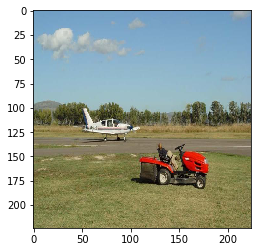

In [77]:
%matplotlib inline
img = validation_data[3]

plt.imshow(img)

In [78]:
pred2 = np.squeeze(pred)

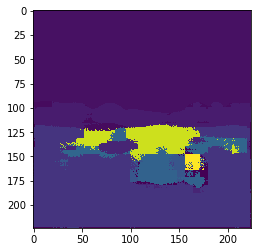

In [79]:
plt.imshow(pred2)

In [80]:
plt.imshow(pred3)

NameError: name 'pred3' is not defined

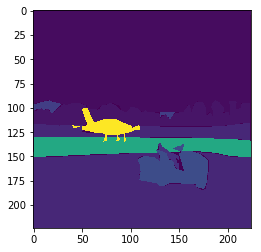

In [81]:
plt.imshow(np.squeeze(validation_labels[3]))